In [9]:
 #GPUを用いて、pytorchを使ったViTモデルを作成する
import pandas as pd
# import tensorflow as tf
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import scipy.io
from tqdm import tqdm 
import torch

#データの読み込み
mat_file = 'mat/60_sin_1period_bpsk_2signal.mat'
data = scipy.io.loadmat(mat_file)

#matファイルの中身の変数名を確認する

data.keys()
a = data['R_xx']
# a = data['R_xx_exist_Noise']
b = data['inputVec']
c = data['label']

sigmax2=data['sigmaX2']

t=data['t']
# print(t)
#matに保存した変数の呼び出し
#a,b,cの次元数を確認する
print(a.shape)
print(b.shape)
print(c.shape)

#共分散行列
R = a
label=c

loop=10

for i in range(loop-1):
    R=np.concatenate((R,a),axis=2)
    label=np.concatenate((label,c),axis=0)

print(R.shape)
print(label.shape)

(10, 10, 1000)
(1000, 101)
(1000, 2)
(10, 10, 10000)
(10000, 2)


In [10]:
# #入力信号の電力
# sigmax2=d
# #スナップショット数
# t=e

#実数部と虚数部(虚数単位jは外す)に分ける関数
def split_complex(x):
    real = np.real(x)
    imag = np.imag(x)
    return real, imag


#実数部と虚数部に分ける
real, imag = split_complex(R)

#実数部と虚数部の次元数を確認する
print(real.shape)
print(imag.shape)

#実数部と虚数部を結合し、四次元配列に変換する
R = np.stack([real, imag], axis=3)

#Rの次元数を確認する
print(R.shape)

#Rはx(t)=As(t)+n(t)という信号モデルの共分散行列(Rはx(t)の複素共役転置の期待値)である（Aは方向行列、s(t)は入力信号、n(t)はガウス雑音）
#Rには、本来Aとs(t)とn(t)の情報が含まれているが、今回はn(t)を含まない
#Rにn(t)を乗せる処理を書く

#SNRを定義する
SNR=np.empty((1,1))
np.append(SNR,30)

#送信電力とSNRから雑音電力を求める
#送信電力は、sigmaX2である
#雑音電力は、sigmaN2である
def calculate_noise_covariance(sigmaX2, SNR, t, R):
    # 送信電力から雑音電力を計算する
    sigman2 = np.divide(sigmaX2, (10**(SNR/10)))

    # sigmaN2を表示する
    # print(sigman2)

    # ガウス分布に従う雑音n(t)を生成する
    noise = np.sqrt(sigman2/2) * (np.random.randn(len(t),len(R[:,0,0,0])) + 1j*np.random.randn(len(t),len(R[:,0,0,0])))

    # n(t)の次元数を確認する
    # print(noise.shape)

    # n(t)の共分散行列を求める
    N = np.dot(np.conj(noise).T, noise)

    # Nの次元数を確認する
    # print("R_n", N.shape)

    # Nの実部と虚部を分割する
    real, imag = np.real(N), np.imag(N)

    # Nを結合して次元数を確認する
    N = np.stack([real, imag], axis=2)
    # print("R_n", N.shape)

    return N

for j in range(len(SNR)):

    # 繰り返し回数と結果を格納するリストの定義
    num_iterations = R.shape[2]
    N = []

    # 繰り返し処理
    for _ in range(num_iterations):
        # 関数の呼び出しと結果の取得
        result = calculate_noise_covariance(sigmax2, SNR, t, R)
        N.append(result)

    N=np.array(N)
    # 結果の出力
    # for i, result in enumerate(results):
    #     print(f"Result {i+1}:\n{result}\n")


    #Nの次元数を確認する
    # print("R", R.shape)
    # print("N", N.shape)

    #Nの0番目と2番目の次元数を入れ替える
    N = np.swapaxes(N, 0, 2)
    # print(N.shape)


    #RにNを足す
    R = R + N
    # print('R.shape',R.shape)

X = R
Y = label



print(X.shape)
#Xを3次元配列に変換する
X = np.reshape(X, (X.shape[2], X.shape[0], X.shape[1], X.shape[3]))

print(X.shape)

from sklearn.model_selection import train_test_split

#学習データセットと検証データセットとテストデータセットの分割割合を変数で指定する
train_size = 0.8
val_size = 0.1
test_size = 0.1

#学習データセットと検証データセットとテストデータセットを分割する(シャッフルはしない)
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=1 - train_size, shuffle=False)
XVal, XTest, YVal, YTest = train_test_split(XTest, YTest, test_size=test_size / (test_size + val_size), shuffle=False)

#学習データセットと検証データセットとテストデータセットの次元数を確認する
print(XTrain.shape)
print(XVal.shape)
print(XTest.shape)
print(YTrain.shape)
print(YVal.shape)
print(YTest.shape)

#入力の次元はそれぞれ(サンプル数、タイムステップ数、特徴量)である
# Xの2番目の次元と3番目の次元を入れ替える
XTrain = np.swapaxes(XTrain, 1, 3)
XVal = np.swapaxes(XVal, 1, 3)
XTest = np.swapaxes(XTest, 1, 3)


#学習データセットと検証データセットとテストデータセットの次元数を確認する
print("----------------")
print(XTrain.shape)
print(XVal.shape)
print(XTest.shape)
print(YTrain.shape)
print(YVal.shape)
print(YTest.shape)


(10, 10, 10000)
(10, 10, 10000)
(10, 10, 10000, 2)
(10, 10, 10000, 2)
(10000, 10, 10, 2)
(8000, 10, 10, 2)
(1000, 10, 10, 2)
(1000, 10, 10, 2)
(8000, 2)
(1000, 2)
(1000, 2)
----------------
(8000, 2, 10, 10)
(1000, 2, 10, 10)
(1000, 2, 10, 10)
(8000, 2)
(1000, 2)
(1000, 2)


In [11]:
from sklearn.model_selection import train_test_split

#学習データセットと検証データセットとテストデータセットの分割割合を変数で指定する
# train_size = 0.8
# val_size = 0.1
# test_size = 0.1
# 
# #学習データセットと検証データセットとテストデータセットを分割する(シャッフルはしない)
# XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=1 - train_size, shuffle=False)
# XVal, XTest, YVal, YTest = train_test_split(XTest, YTest, test_size=test_size / (test_size + val_size), shuffle=False)
# 
# #学習データセットと検証データセットとテストデータセットの次元数を確認する
# print(XTrain.shape)
# print(XVal.shape)
# print(XTest.shape)
# print(YTrain.shape)
# print(YVal.shape)
# print(YTest.shape)




In [12]:
from torch.utils.data import DataLoader
#pytorchでのViTの実装
import torch
from vit_pytorch import ViT

XTrain=torch.FloatTensor(XTrain)
XVal=torch.FloatTensor(XVal)
XTest=torch.FloatTensor(XTest)
YTrain=torch.FloatTensor(YTrain)
YVal=torch.FloatTensor(YVal)
YTest=torch.FloatTensor(YTest)

Dataset_train = torch.utils.data.TensorDataset(XTrain, YTrain)
Dataset_val = torch.utils.data.TensorDataset(XVal, YVal)
Dataset_test = torch.utils.data.TensorDataset(XTest, YTest)

X_sample, y_sample = Dataset_train[0]
print(X_sample, y_sample)
batch_size = 32

train_loader = DataLoader(dataset = Dataset_train, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = Dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = Dataset_train, batch_size=batch_size, shuffle=True)

tensor([[[178.5566, 203.2116, 226.2144, 205.4617, 219.3922, 206.8442, 190.0326,
          195.5954, 205.0042, 198.6296],
         [197.9975, 209.1307, 208.8246, 209.0579, 191.8882, 198.6481, 208.7677,
          202.6179, 212.3744, 222.8536],
         [211.6037, 185.0160, 205.9583, 186.7566, 201.4909, 226.4475, 207.0111,
          186.8232, 183.9675, 188.7362],
         [218.5253, 227.5741, 188.2650, 205.6237, 187.6031, 182.0199, 196.7366,
          204.0526, 210.4445, 205.9383],
         [223.6752, 172.5849, 208.1568, 174.5844, 217.9298, 207.2027, 227.5067,
          191.1805, 214.8840, 196.5103],
         [201.7951, 218.9229, 217.0637, 198.6113, 214.8759, 184.0698, 202.2646,
          191.3552, 194.3965, 186.2613],
         [230.2507, 187.1354, 208.0122, 171.3708, 187.9412, 235.9746, 219.5634,
          216.6669, 209.1167, 218.0125],
         [191.6526, 192.1590, 221.8696, 192.6059, 217.6520, 206.6221, 196.8731,
          176.6768, 218.8793, 193.4862],
         [211.1207, 196.5240, 20

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# 
# net = ViT(
#     image_size=10,
#     patch_size=2,
#     num_classes=2,
#     dim=256,
#     depth=3,
#     heads=4,
#     mlp_dim=256,
#     dropout=0.1,
#     emb_dropout=0.1
# ).to(device)

#回帰ViTモデルインスタンスを作成
net = ViT(
    image_size=10,
    patch_size=2,
    num_classes=2,
    dim=256,
    depth=3,
    heads=4,
    mlp_dim=256,
    dropout=0.2,
    emb_dropout=0.2,
    channels=2
).to(device)

print(net)
# net.mlp_head.out_features=

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=2, p2=2)
    (1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=8, out_features=256, bias=True)
    (3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-2): 3 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.2, inplace=False)
          (to_qkv): Linear(in_features=256, out_features=768, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): Dropout(p=0.2, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): Laye

In [14]:
import torchvision.models as models
from torchinfo import summary

batch_size = 16
summary(model=net, input_size=(batch_size, 2, 10, 10))


# print((data[0].to(device)).shape)

Layer (type:depth-idx)                             Output Shape              Param #
ViT                                                [16, 2]                   6,912
├─Sequential: 1-1                                  [16, 25, 256]             --
│    └─Rearrange: 2-1                              [16, 25, 8]               --
│    └─LayerNorm: 2-2                              [16, 25, 8]               16
│    └─Linear: 2-3                                 [16, 25, 256]             2,304
│    └─LayerNorm: 2-4                              [16, 25, 256]             512
├─Dropout: 1-2                                     [16, 26, 256]             --
├─Transformer: 1-3                                 [16, 26, 256]             --
│    └─ModuleList: 2-5                             --                        --
│    │    └─ModuleList: 3-1                        --                        395,008
│    │    └─ModuleList: 3-2                        --                        395,008
│    │    └─Module

In [15]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

epochs = 20
lr = 1e-2
gamma = 0.9

##ここを追記↓##
train_mse_list = []
val_mse_list = []
train_loss_list = []
val_loss_list = []

# epoch_loss = []
# epoch_accuracy = []
##############

#回帰用損失関数
criterion = nn.MSELoss()
optimizer =optim.Adam(net.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)




for epoch in range(epochs):
    epoch_loss = 0
    epoch_mse = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        
        # print(type(label))
        
        output = net(data)
        # print(output)
        
        # print(type(output))
        
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#推定値と正解値の平均二乗誤差を計算する
        mse = torch.mean(torch.square(output - label))
        epoch_mse += mse / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_mse = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = net(data)
            # print(val_output)
            val_loss = criterion(val_output, label)

            mse = torch.mean(torch.square(val_output - label))
            epoch_val_mse += mse / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - mse: {epoch_mse:.4f} - val_loss : {epoch_val_loss:.4f} - val_mse: {epoch_val_mse:.4f}\n"
    )

    ##ここを追記↓##
    train_mse_list.append(epoch_mse)
    val_mse_list.append(epoch_val_mse)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)
    ##############


100%|██████████| 250/250 [00:01<00:00, 167.62it/s]


Epoch : 1 - loss : 1804.9608 - mse: 1804.9608 - val_loss : 1806.5863 - val_mse: 1806.5863


100%|██████████| 250/250 [00:01<00:00, 181.67it/s]


Epoch : 2 - loss : 1801.6261 - mse: 1801.6261 - val_loss : 1800.7227 - val_mse: 1800.7227


100%|██████████| 250/250 [00:01<00:00, 177.66it/s]


Epoch : 3 - loss : 1801.8105 - mse: 1801.8105 - val_loss : 1798.8778 - val_mse: 1798.8778


100%|██████████| 250/250 [00:01<00:00, 180.18it/s]


Epoch : 4 - loss : 1801.2510 - mse: 1801.2510 - val_loss : 1800.4983 - val_mse: 1800.4983


100%|██████████| 250/250 [00:01<00:00, 182.98it/s]


Epoch : 5 - loss : 1800.9425 - mse: 1800.9425 - val_loss : 1800.7527 - val_mse: 1800.7527


100%|██████████| 250/250 [00:01<00:00, 179.38it/s]


Epoch : 6 - loss : 1799.0775 - mse: 1799.0775 - val_loss : 1807.3882 - val_mse: 1807.3882


100%|██████████| 250/250 [00:01<00:00, 178.80it/s]


Epoch : 7 - loss : 1799.4268 - mse: 1799.4268 - val_loss : 1797.2378 - val_mse: 1797.2378


100%|██████████| 250/250 [00:01<00:00, 179.65it/s]


Epoch : 8 - loss : 1798.3596 - mse: 1798.3596 - val_loss : 1794.8013 - val_mse: 1794.8013


100%|██████████| 250/250 [00:01<00:00, 180.45it/s]


Epoch : 9 - loss : 1798.4672 - mse: 1798.4672 - val_loss : 1799.2043 - val_mse: 1799.2043


100%|██████████| 250/250 [00:01<00:00, 177.18it/s]


Epoch : 10 - loss : 1800.0068 - mse: 1800.0068 - val_loss : 1797.9069 - val_mse: 1797.9069


100%|██████████| 250/250 [00:01<00:00, 179.25it/s]


Epoch : 11 - loss : 1799.7207 - mse: 1799.7207 - val_loss : 1798.2654 - val_mse: 1798.2654


100%|██████████| 250/250 [00:01<00:00, 205.65it/s]


Epoch : 12 - loss : 1799.5129 - mse: 1799.5129 - val_loss : 1797.1436 - val_mse: 1797.1436


100%|██████████| 250/250 [00:01<00:00, 206.76it/s]


Epoch : 13 - loss : 1796.8914 - mse: 1796.8914 - val_loss : 1793.1122 - val_mse: 1793.1122


100%|██████████| 250/250 [00:01<00:00, 205.26it/s]


Epoch : 14 - loss : 1796.6005 - mse: 1796.6005 - val_loss : 1796.0028 - val_mse: 1796.0028


100%|██████████| 250/250 [00:01<00:00, 203.53it/s]


Epoch : 15 - loss : 1796.5146 - mse: 1796.5146 - val_loss : 1801.0234 - val_mse: 1801.0234


100%|██████████| 250/250 [00:01<00:00, 203.35it/s]


Epoch : 16 - loss : 1796.6461 - mse: 1796.6461 - val_loss : 1797.8081 - val_mse: 1797.8081


100%|██████████| 250/250 [00:01<00:00, 204.83it/s]


Epoch : 17 - loss : 1796.1895 - mse: 1796.1895 - val_loss : 1800.6816 - val_mse: 1800.6816


100%|██████████| 250/250 [00:01<00:00, 204.98it/s]


Epoch : 18 - loss : 1797.9608 - mse: 1797.9608 - val_loss : 1796.8740 - val_mse: 1796.8740


100%|██████████| 250/250 [00:01<00:00, 203.58it/s]


Epoch : 19 - loss : 1798.9386 - mse: 1798.9386 - val_loss : 1800.4648 - val_mse: 1800.4648


100%|██████████| 250/250 [00:01<00:00, 204.90it/s]


Epoch : 20 - loss : 1798.3901 - mse: 1798.3901 - val_loss : 1797.0398 - val_mse: 1797.0398


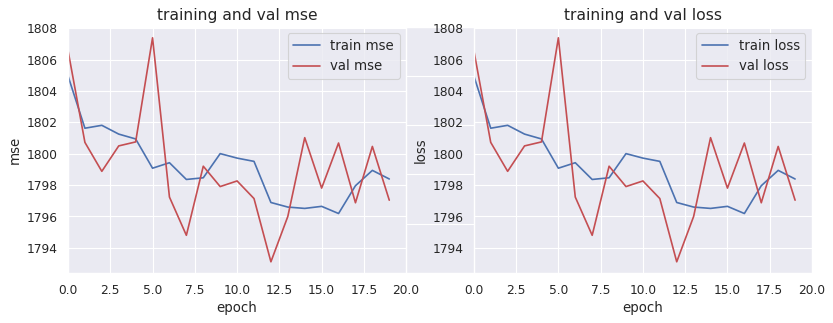

In [16]:
import seaborn as sns

device2 = torch.device('cpu')

train_mse = []
train_loss = []
val_mse = []
val_loss = []

for i in range(epochs):
    train_mse2 = train_mse_list[i].to(device2)
    train_mse3 = train_mse2.clone().detach().numpy()
    train_mse.append(train_mse3)
    
    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)
    
    val_mse2 = val_mse_list[i].to(device2)
    val_mse3 = val_mse2.clone().detach().numpy()
    val_mse.append(val_mse3)
    
    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().detach().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
# plt.tight_layout()


ax1 = plt.subplot(1,2,1,)

plt.xlim(0, num_epochs)
ax1.plot(range(num_epochs), train_mse, c='b', label='train mse')
ax1.plot(range(num_epochs), val_mse, c='r', label='val mse')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('mse', fontsize='12')
ax1.set_title('training and val mse', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
plt.xlim(0, num_epochs)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()